# Assignment 8: Data Aggregation and Group Operations

## Overview
This assignment covers data aggregation and group operations using healthcare/insurance EHR data. You'll analyze patient encounters (insurance claims), healthcare providers, and medical facilities across different regions. The data includes provider statistics, facility information, and encounter charges with insurance coverage details.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seed for reproducibility
np.random.seed(42)

# Create output directory
os.makedirs('output', exist_ok=True)

## Question 1: Basic GroupBy Operations

### Part 1.1: Load and Explore Data

**TODO: Load and merge the datasets**

In [2]:
# TODO: Load the three CSV files into dataframes
provider_df = pd.read_csv('data/provider_data.csv')
facility_df = pd.read_csv('data/facility_data.csv')
encounter_df = pd.read_csv('data/encounter_data.csv')

# TODO: Print the shapes of each dataframe
print("Provider data shape:", provider_df.shape)
print("Facility data shape:", facility_df.shape)
print("Encounter data shape:", encounter_df.shape)

# TODO: Merge the dataframes for analysis
# Hint: Start by merging encounter_df with provider_df on 'provider_id'
#       Then merge the result with facility_df on 'facility_id'
# Note: Both encounter_df and provider_df have 'facility_id', and both encounter_df and facility_df have 'region'
#       After merging, you may need to handle duplicate column names (pandas will add suffixes like _x and _y)
#       You can drop one of the duplicate columns and rename if needed
merged_df = encounter_df.merge(provider_df, on='provider_id')
merged_df = merged_df.drop(columns=['facility_id_y']).rename(columns={'facility_id_x': 'facility_id'})
merged_df = merged_df.merge(facility_df, on='facility_id')
merged_df = merged_df.drop(columns=['region_y']).rename(columns={'region_x': 'region'})

# TODO: Print the merged dataframe shape, columns, and first few rows
print("\nMerged data shape:", merged_df.shape)
print("\nColumns:", merged_df.columns)
print("\nFirst few rows:")
display(merged_df.head())

Provider data shape: (500, 7)
Facility data shape: (10, 6)
Encounter data shape: (5000, 12)

Merged data shape: (5000, 21)

Columns: Index(['encounter_id', 'patient_id', 'provider_id', 'facility_id',
       'encounter_date', 'encounter_type', 'diagnosis_code', 'procedure_code',
       'service_charge', 'insurance_paid', 'patient_paid', 'region',
       'provider_name', 'provider_type', 'specialty', 'years_experience',
       'license_number', 'facility_name', 'facility_type', 'beds',
       'established_date'],
      dtype='object')

First few rows:


,encounter_id,patient_id,provider_id,facility_id,encounter_date,encounter_type,diagnosis_code,procedure_code,service_charge,insurance_paid,...,region,provider_name,provider_type,specialty,years_experience,license_number,facility_name,facility_type,beds,established_date
0,ENC00001,PAT01564,PR0259,FAC004,2023-08-21,Office Visit,M79.3,99213,345.03,290.33,...,West,Quinn Anderson,Nurse,Pediatrics,11,LIC000259,Northside Urgent Care,Urgent Care,313,1994-10-04
1,ENC00002,PAT00296,PR0258,FAC001,2023-09-11,Inpatient,N18.9,85025,550.48,482.51,...,South,Drew Martinez,Therapist,Endocrinology,19,LIC000258,City General Hospital,Urgent Care,276,1999-11-27
2,ENC00003,PAT01381,PR0213,FAC001,2023-03-20,Lab,K21.9,80053,149.84,116.67,...,South,Jordan Anderson,Physician,Dermatology,3,LIC000213,City General Hospital,Urgent Care,276,1999-11-27
3,ENC00004,PAT01131,PR0146,FAC004,2023-09-03,Outpatient Procedure,H52.9,70450,1468.48,1198.71,...,West,Taylor Rodriguez,Nurse Practitioner,Oncology,6,LIC000146,Northside Urgent Care,Urgent Care,313,1994-10-04
4,ENC00005,PAT01388,PR0354,FAC003,2023-06-14,Emergency,G43.9,99214,672.23,507.22,...,South,Drew Anderson,Physician Assistant,Endocrinology,36,LIC000354,Regional Medical Center,Urgent Care,459,1982-05-10


### Part 1.2: Basic Aggregation

**TODO: Perform basic groupby operations**

In [ ]:
# TODO: Group by facility (healthcare facility) and calculate basic stats
# TODO: Calculate mean, sum, count for years_experience by facility
# TODO: Calculate total encounter charges by facility
# TODO: Calculate total insurance payments by facility
# TODO: Find the facility with highest total encounter charges
summary1 = merged_df.groupby('facility_name').agg(
    {
        'years_experience' : ['mean', 'sum', 'count'],
        'service_charge' : ['sum'],
        'insurance_paid' : ['sum']
    }
).reset_index()

print("Facility with highest total encounter charges")
display(summary1.sort_values(by=(('service_charge', 'sum')), ascending=False).head(1))

# TODO: Create a summary dataframe with one row per facility showing:
#       facility_name, total_providers, avg_years_experience, total_service_charge, total_insurance_paid
summary2 = pd.DataFrame({
    'total_providers': merged_df.groupby('facility_name')['provider_id'].agg('nunique'),
    'avg_years_experience' : merged_df.groupby('facility_name')['years_experience'].agg('mean'),
    'total_service_charge' : merged_df.groupby('facility_name')['service_charge'].agg('sum'),
    'total_insurance_paid' : merged_df.groupby('facility_name')['insurance_paid'].agg('sum')
})

summary2 = summary2.reset_index()
display(summary2)

# TODO: Save the summary dataframe as 'output/q1_groupby_analysis.csv'
summary2.to_csv("output/q1_groupby_analysis.csv", index=False)

Facility with highest total encounter charges


facility_name years_experience              service_charge  \
                                     mean    sum count            sum   
6  Pediatric Care Center        19.811676  10520   531      361811.04   

  insurance_paid  
             sum  
6      291790.95

,facility_name,total_providers,avg_years_experience,total_service_charge,total_insurance_paid
0,Cardiology Specialty Center,297,19.319728,276658.83,222139.04
1,City General Hospital,312,19.563008,295508.13,236798.50
2,Community Health Clinic,328,20.160784,334992.21,269207.92
3,Emergency Medical Center,299,19.668687,310735.25,248439.20
4,Northside Urgent Care,305,20.137014,297283.06,236839.71
5,Oncology Treatment Center,324,19.381139,334927.30,267183.95
6,Pediatric Care Center,326,19.811676,361811.04,291790.95
7,Primary Care Clinic,316,20.102970,323315.71,260297.44
8,Regional Medical Center,309,20.209205,316284.98,251750.43
9,Surgical Specialty Center,340,20.778182,349909.18,278503.38


### Part 1.3: Transform Operations

**TODO: Use transform operations to add group statistics**

In [ ]:
# TODO: Add facility mean years_experience as new column
# TODO: Add facility standard deviation of years_experience
# TODO: Create normalized years_experience (z-score within facility)
# TODO: Add facility total encounter charges as new column
summary2['Year_experience_Mean'] = summary2['avg_years_experience']
summary2['Years_experience_Std'] = merged_df.groupby('facility_name')['years_experience'].transform('std')
summary2['Years_experience_Normalized'] = merged_df.groupby('facility_name')['years_experience'].transform(lambda x: (x - x.mean()) / x.std())
summary2['Total_encounter_charges'] = summary2['total_service_charge']

# TODO: Display the enhanced dataframe
display(summary2)

# TODO: Save results as 'output/q1_aggregation_report.txt'
with open('output/q1_aggregation_report.txt', 'w') as file:
    file.write('Assignment 8 Question 1 Aggregation Report\n')
    summary2.to_csv(file, index=False)

,facility_name,total_providers,avg_years_experience,total_service_charge,total_insurance_paid,Year_experience_Mean,Years_experience_Std,Years_experience_Normalized,Total_encounter_charges
0,Cardiology Specialty Center,297,19.319728,276658.83,222139.04,19.319728,10.581439,-0.863495,276658.83
1,City General Hospital,312,19.563008,295508.13,236798.50,19.563008,10.702137,-0.052607,295508.13
2,Community Health Clinic,328,20.160784,334992.21,269207.92,20.160784,10.702137,-1.547636,334992.21
3,Emergency Medical Center,299,19.668687,310735.25,248439.20,19.668687,10.581439,-1.336020,310735.25
4,Northside Urgent Care,305,20.137014,297283.06,236839.71,20.137014,11.575935,1.364105,297283.06
5,Oncology Treatment Center,324,19.381139,334927.30,267183.95,19.381139,10.581439,-0.579979,334927.30
6,Pediatric Care Center,326,19.811676,361811.04,291790.95,19.811676,10.581439,-0.863495,361811.04
7,Primary Care Clinic,316,20.102970,323315.71,260297.44,20.102970,10.702137,0.321150,323315.71
8,Regional Medical Center,309,20.209205,316284.98,251750.43,20.209205,10.581439,-1.336020,316284.98
9,Surgical Specialty Center,340,20.778182,349909.18,278503.38,20.778182,11.358132,-1.653281,349909.18


## Question 2: Advanced GroupBy Operations

### Part 2.1: Filter Operations

**TODO: Use filter operations to remove groups**

In [5]:
# TODO: Filter facilities with more than 20 providers (sufficient staffing)
# TODO: Filter facilities with average years_experience > 10 (experienced staff)
# TODO: Filter facilities with total encounter charges > 250000 (high volume)
filtered = summary2.groupby('facility_name').filter(lambda x: x['total_providers']>20)
filtered = filtered.groupby('facility_name').filter(lambda x: x['avg_years_experience']>10)
filtered = filtered.groupby('facility_name').filter(lambda x: x['Total_encounter_charges']>250000)

# TODO: Create a summary of filtered results
display(filtered)

# TODO: Save results as 'output/q2_filter_analysis.csv'
filtered.to_csv('output/q2_filter_analysis.csv', index=False)

,facility_name,total_providers,avg_years_experience,total_service_charge,total_insurance_paid,Year_experience_Mean,Years_experience_Std,Years_experience_Normalized,Total_encounter_charges
0,Cardiology Specialty Center,297,19.319728,276658.83,222139.04,19.319728,10.581439,-0.863495,276658.83
1,City General Hospital,312,19.563008,295508.13,236798.50,19.563008,10.702137,-0.052607,295508.13
2,Community Health Clinic,328,20.160784,334992.21,269207.92,20.160784,10.702137,-1.547636,334992.21
3,Emergency Medical Center,299,19.668687,310735.25,248439.20,19.668687,10.581439,-1.336020,310735.25
4,Northside Urgent Care,305,20.137014,297283.06,236839.71,20.137014,11.575935,1.364105,297283.06
5,Oncology Treatment Center,324,19.381139,334927.30,267183.95,19.381139,10.581439,-0.579979,334927.30
6,Pediatric Care Center,326,19.811676,361811.04,291790.95,19.811676,10.581439,-0.863495,361811.04
7,Primary Care Clinic,316,20.102970,323315.71,260297.44,20.102970,10.702137,0.321150,323315.71
8,Regional Medical Center,309,20.209205,316284.98,251750.43,20.209205,10.581439,-1.336020,316284.98
9,Surgical Specialty Center,340,20.778182,349909.18,278503.38,20.778182,11.358132,-1.653281,349909.18


### Part 2.2: Apply Operations

**TODO: Use apply operations with custom functions**

In [ ]:
# TODO: Create custom function to calculate provider statistics
def provider_stats(group):
    # TODO: Return mean, std, min, max, range for years_experience
    return pd.Series({
    'mean_yr_exp' : group['years_experience'].mean(),
    'std_yr_exp' : group['years_experience'].std(),
    'min_yr_exp' : group['years_experience'].min(),
    'max_yr_exp' : group['years_experience'].max(),
    'range_yr_exp' : group['years_experience'].max() - group['years_experience'].min()
    })


# TODO: Apply custom function to each facility
# Note: Add include_groups=False to avoid pandas FutureWarning about groupby columns
facility_provider_stats = merged_df.groupby('facility_name').apply(provider_stats, include_groups=False)

# TODO: Create function to find top providers in each facility
def top_providers(group, n=2):
    """Return top n providers in a group by encounter volume"""
    # TODO: Return top n rows by encounter count, selecting only provider_id, provider_name, 
    #       years_experience, specialty
    top_p = group.groupby(['provider_id', 'provider_name', 'years_experience', 'specialty'])['encounter_id'].count()
    top_p = top_p.reset_index(name='encounter_count')
    top_p = top_p.nlargest(n, 'encounter_count')
    return top_p

# TODO: Apply function to get top 2 providers per facility
# IMPORTANT: When using groupby().apply(), the result has a MultiIndex where:
# - Level 0: The grouping column (facility_name)
# - Level 1: The original row index from each group
# Use reset_index(level=0) to move only the grouping column back to a regular column
# DO NOT use reset_index(drop=True) - that would drop ALL index levels including facility_name!
top_providers_by_facility = merged_df.groupby('facility_name').apply(
    lambda x: top_providers(x, n=2)
).reset_index(level=0)  # Moves facility_name from index to column

# TODO: Save results as 'output/q2_performance_report.txt'
with open('output/q2_performance_report.txt', 'w') as file:
    file.write('Assignment 8 Question 2 Performance Report\n')
    top_providers_by_facility.to_csv(file, index=False)

/var/folders/5t/lfb7y4m975b78bly378zr4880000gn/T/ipykernel_56460/813878393.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_providers_by_facility = merged_df.groupby('facility_name').apply(


### Part 2.3: Hierarchical Grouping

**TODO: Perform multi-level grouping**

In [20]:
# TODO: Group by facility type and region
# TODO: Calculate statistics for each facility_type-region combination
# TODO: Use unstack to convert to wide format
# TODO: Use stack to convert back to long format
facility_type_region = merged_df.groupby(['facility_type', 'region']).agg({
    'service_charge': 'sum',
    'insurance_paid': 'sum',
    'patient_paid': 'sum'
})

facility_type_region = facility_type_region.unstack(level='region')
display("Wide format:")
display(facility_type_region)

facility_type_region = facility_type_region.stack(level='region', future_stack=True)
display("Long format:")
display(facility_type_region)

# TODO: Analyze the hierarchical structure
print('Hierarchical structure:')
print(facility_type_region.info())
# TODO: Save results as 'output/q2_hierarchical_analysis.csv'
facility_type_region.to_csv('output/q2_hierarchical_analysis.csv')

'Wide format:'

service_charge                       insurance_paid  \
region                    North      South       West          North   
facility_type                                                          
Hospital                    NaN  334927.30        NaN            NaN   
Specialty Center            NaN  672546.29  599974.54            NaN   
Urgent Care           334992.21  611793.11  647192.24      269207.92   

                                       patient_paid                        
region                South       West        North      South       West  
facility_type                                                              
Hospital          267183.95        NaN          NaN   67743.35        NaN  
Specialty Center  540230.15  482436.48          NaN  132316.14  117538.06  
Urgent Care       488548.93  515343.09     65784.29  123244.18  131849.15

'Long format:'

service_charge  insurance_paid  patient_paid
facility_type    region                                              
Hospital         North              NaN             NaN           NaN
                 South        334927.30       267183.95      67743.35
                 West               NaN             NaN           NaN
Specialty Center North              NaN             NaN           NaN
                 South        672546.29       540230.15     132316.14
                 West         599974.54       482436.48     117538.06
Urgent Care      North        334992.21       269207.92      65784.29
                 South        611793.11       488548.93     123244.18
                 West         647192.24       515343.09     131849.15

Hierarchical structure:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9 entries, ('Hospital', 'North') to ('Urgent Care', 'West')
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   service_charge  6 non-null      float64
 1   insurance_paid  6 non-null      float64
 2   patient_paid    6 non-null      float64
dtypes: float64(3)
memory usage: 383.0+ bytes
None


## Question 3: Pivot Tables and Cross-Tabulations

### Part 3.1: Basic Pivot Tables

**TODO: Create pivot tables for multi-dimensional analysis**

In [17]:
# TODO: Create pivot table: encounter charges by procedure code and region
code_region = pd.pivot_table(merged_df, values='service_charge', index='procedure_code', columns='region')
display('Average encounter charges by procedure code and region')
display(code_region)

# TODO: Create pivot table with multiple aggregations (sum, mean, count)
# TODO: Add totals (margins) to pivot table
# TODO: Handle missing values with fill_value
q3_pivot = pd.pivot_table(merged_df, 
               values='service_charge', 
               index='procedure_code', 
               columns='region', 
               aggfunc=['sum', 'mean', 'count'],
               margins=True,
               margins_name='Total',
               fill_value=0
               )
display('Encounter charge summary by procedure code and region')
display(q3_pivot)

# Tip: When saving a pivot table to CSV, the index (row labels) is preserved by default.
#      This is usually desired - when reading back, use index_col=0 to restore the index.
# TODO: Save results as 'output/q3_pivot_analysis.csv'
code_region.to_csv('output/q3_pivot_analysis.csv')

'Average encounter charges by procedure code and region'

region,North,South,West
procedure_code,,,
36415,466.551923,416.093309,425.070614
70450,3222.744643,2665.909220,2623.567479
70551,2935.823889,2762.556000,2925.296727
72040,369.784839,471.160349,425.559323
80053,284.578654,297.339645,269.771382
85025,255.616286,312.035924,287.106549
93000,354.909474,382.694178,440.820962
99213,460.321630,498.116682,473.935631
99214,465.481039,489.426480,474.496858


'Encounter charge summary by procedure code and region'

sum                                             mean  \
region              North       South        West       Total        North   
procedure_code                                                               
36415            12130.35    57836.97    48458.05   118425.37   466.551923   
70450            90236.85   375893.20   312204.53   778334.58  3222.744643   
70551            52844.83   234817.26   160891.32   448553.41  2935.823889   
72040            11463.33    81039.58    56599.39   149102.30   369.784839   
80053            14798.09    83849.78    58540.39   157188.26   284.578654   
85025             8946.57    48989.64    40769.13    98705.34   255.616286   
93000             6743.28    55873.35    45845.38   108462.01   354.909474   
99213            62143.42   327262.66   259242.79   648648.87   460.321630   
99214            71684.08   322532.05   240095.41   634311.54   465.481039   
99283             4001.41    31172.21    24520.39    59694.01   333.450833   
Total           334992.21  1619266.70  1247166.78  3201425.69   656.847471   

                                                      count                    
region                South         West        Total North South  West Total  
procedure_code                                                                 
36415            416.093309   425.070614   424.463692    26   139   114   279  
70450           2665.909220  2623.567479  2702.550625    28   141   119   288  
70551           2762.556000  2925.296727  2838.945633    18    85    55   158  
72040            471.160349   425.559323   443.756845    31   172   133   336  
80053            297.339645   269.771382   285.278149    52   282   217   551  
85025            312.035924   287.106549   295.524970    35   157   142   334  
93000            382.694178   440.820962   403.204498    19   146   104   269  
99213            498.116682   473.935631   484.427834   135   657   547  1339  
99214            489.426480   474.496858   480.903366   154   659   506  1319  
99283            465.256866   510.841458   470.031575    12    67    48   127  
Total            646.413852   628.295607   640.285138   510  2505  1985  5000

### Part 3.2: Cross-Tabulations

**TODO: Create cross-tabulations for categorical analysis**

In [ ]:
# TODO: Create crosstab of facility type vs region with counts
# TODO: Create crosstab with margins (row and column totals)
# TODO: Create multi-dimensional crosstab showing facility type × encounter type × region combinations
#       (Hint: use pd.crosstab with multiple index/column parameters, or create manually from the data)
type_region_cross = pd.crosstab(merged_df['facility_type'], merged_df['region'], margins=True) 
facility_encounter_region = pd.crosstab([merged_df['facility_type'], merged_df['encounter_type']], merged_df['region'], margins=True) 

# TODO: Analyze the cross-tabulation results
print('Facility type vs region with counts')
display(type_region_cross)
print('Facility type × encounter type × region combinations')
display(facility_encounter_region)

# TODO: Save results as 'output/q3_crosstab_analysis.csv'
facility_encounter_region.to_csv('output/q3_crosstab_analysis.csv')

Facility type vs region with counts


region,North,South,West,All
facility_type,,,,
Hospital,0,509,0,509
Specialty Center,0,1026,946,1972
Urgent Care,510,970,1039,2519
All,510,2505,1985,5000


Facility type × encounter type × region combinations


region                                 North  South  West   All
facility_type    encounter_type                                
Hospital         Emergency                 0    127     0   127
                 Inpatient                 0     95     0    95
                 Lab                       0    100     0   100
                 Office Visit              0     85     0    85
                 Outpatient Procedure      0    102     0   102
Specialty Center Emergency                 0    236   182   418
                 Inpatient                 0    210   191   401
                 Lab                       0    211   180   391
                 Office Visit              0    175   200   375
                 Outpatient Procedure      0    194   193   387
Urgent Care      Emergency               109    190   195   494
                 Inpatient                90    190   201   481
                 Lab                      90    229   228   547
                 Office Visit            112    178   200   490
                 Outpatient Procedure    109    183   215   507
All                                      510   2505  1985  5000

### Part 3.3: Pivot Table Visualization

**TODO: Create visualizations from pivot tables**

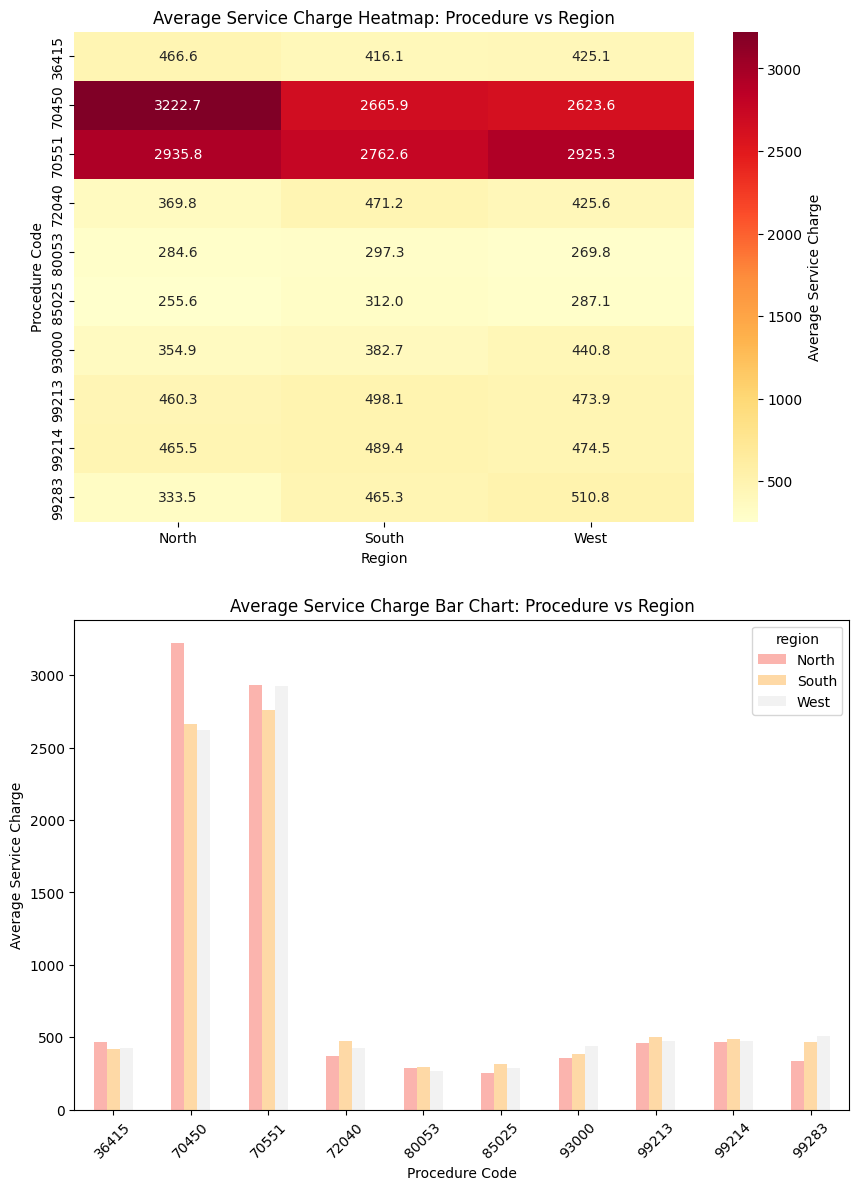

In [11]:
# TODO: Create heatmap from pivot table
# TODO: Create bar chart from pivot table
# TODO: Customize colors and styling
# TODO: Add appropriate titles and labels
fig, axes = plt.subplots(2, 1, figsize=(10, 14))
sns.heatmap(
    code_region,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar_kws={"label": "Average Service Charge"},
    ax=axes[0],
)
axes[0].set_title('Average Service Charge Heatmap: Procedure vs Region')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Procedure Code')

code_region.plot(kind="bar", colormap="Pastel1", ax=axes[1], rot=45)
axes[1].set_title('Average Service Charge Bar Chart: Procedure vs Region')
axes[1].set_xlabel('Procedure Code')
axes[1].set_ylabel('Average Service Charge')

# TODO: Save the plot as 'output/q3_pivot_visualization.png'
plt.savefig("output/q3_pivot_visualization.png", dpi=300, bbox_inches="tight")

## Submission Checklist

Before submitting, verify you've created:

- [ ] `output/q1_groupby_analysis.csv` - Basic groupby analysis
- [ ] `output/q1_aggregation_report.txt` - Aggregation report
- [ ] `output/q2_filter_analysis.csv` - Filter operations analysis
- [ ] `output/q2_hierarchical_analysis.csv` - Hierarchical analysis
- [ ] `output/q2_performance_report.txt` - Performance report
- [ ] `output/q3_pivot_analysis.csv` - Pivot table analysis
- [ ] `output/q3_crosstab_analysis.csv` - Cross-tabulation analysis
- [ ] `output/q3_pivot_visualization.png` - Pivot visualization

## Key Learning Objectives

- Master the split-apply-combine paradigm
- Apply aggregation functions and transformations
- Create pivot tables for multi-dimensional analysis
- Apply advanced groupby techniques